# Activate GPU and install fast.ai

In [0]:
#Change runtime to GPU by clicking "Runtime">"Change Runtime type">"Hardware accelerator">"GPU"

In [0]:
#Test if GPU running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [309]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# IMPORT REQUIRED MODELS

In [0]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer

# Prepare data

In [0]:
# Not excluding stopwords as it performs better
stops={}

In [0]:
#PREPROCEESING THE TEXT

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_no_short_words

In [0]:
#Connect to google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


In [69]:
# Upload newdata.csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving New_data.csv to New_data (1).csv
User uploaded file "New_data.csv" with length 2655848 bytes


In [0]:
#load and prepare new data
newdata=pd.read_csv('New_data.csv')
sentiment_new = newdata['Sentiment'].values

#Filter only English
newdata=newdata[newdata['Language']=="eng"]


In [0]:
# Preprocess

#reviews and sentiment as values
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#test train split
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews_new, sentiment_new, test_size=0.4,random_state=0,stratify=sentiment_new)

#bag of words
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(reviews_train)):
    reviews_train[i] = text_preprocessing(reviews_train[i], language, minWordLength)
for i in range(len(reviews_test)):
    reviews_test[i] = text_preprocessing(reviews_test[i], language, minWordLength)
        

# Create and train models

In [333]:
# Create language databunch with tokens
data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                  valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                  path = "",
                                 text_cols=0,
                                 label_cols=1)


In [0]:
data_lm.show_batch()

In [0]:
# Vocabulary - First 20 unique tokens
data_lm.vocab.itos[:20]

In [346]:
# Replacing tokens with numbers
data_lm.train_ds[0][0].data[:10]

array([  2,  82,  17,  10,  29, 189, 229,  67])

In [0]:
# Load pre-trained (Wikipedia) model, which predicts the next word
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5);

In [268]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


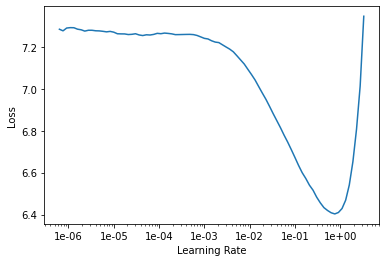

In [269]:
learn.recorder.plot()

In [270]:
# Train learn object with learning rate: 1e-2
# Run this twice
learn.fit_one_cycle(1, 1e-1)
learn.save_encoder('fit_encoder')


epoch,train_loss,valid_loss,accuracy,time
0,5.675529,4.945687,0.172827,00:05


In [271]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.646956,4.554118,0.206931,00:05


In [273]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.068013,4.497844,0.215801,00:06
1,3.974635,4.512994,0.216201,00:05


In [274]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.870524,4.508984,0.216083,00:06
1,3.856811,4.507975,0.216177,00:05


In [275]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,3.863426,4.508053,0.216060,00:06
1,3.854947,4.508315,0.216107,00:06


In [276]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,3.853776,4.507786,0.216118,00:06
1,3.848368,4.508573,0.216142,00:06


In [277]:
learn.predict("The review is:",n_words=10)


'The review is: assign over all of all the staff is who pub'

In [0]:
learn.save_encoder('fit_encoder')

In [350]:
# Create classifier databunch
data_class = TextClasDataBunch.from_df(path="",train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                    valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}),
                                    vocab=data_lm.train_ds.vocab, bs=32)


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
 medium servic good place for burger but not for regular lunch ,  prima sera in peterborough subito una gran buona cena in ottimo hamburg innaffiato da un'ottima birra cameriera cortes che ci ha accudito in tutto per tutto first night in peterborough and first great dinner veri good hamburg with as far as the beer waitress veri kind that help us in everyth ,  this place was exact what it should be good burger solid servic and good menu kevin took great care of us was transpar kind and good server the burger were veri tasti as well and we didn't leav hungri for fair price ,  portug recommend head to lisbon and the algarv in two week and need all of your rec on where to eat drink what activ to do what to see etc travelthelif ,  awesom food great steak ...
  if getat

In [0]:
# Now build a classifier with fine tuned encoder
classifier = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.3)

In [0]:
classifier.load_encoder('fit_encoder')

In [354]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
classifier.recorder.plot()

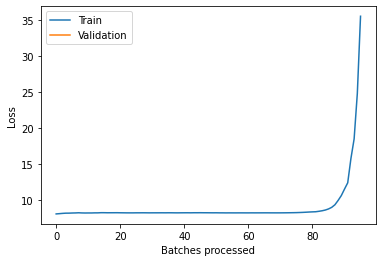

In [356]:
classifier.recorder.plot_losses()

In [0]:
# Fit model 
classifier.unfreeze()
classifier.fit_one_cycle(1, 1e-1)

In [361]:
# Fit model again
# Run this twice - same with 1e-1, 1e-3
classifier.unfreeze()
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,9.255538,6.964733,0.285714,00:02


In [379]:
classifier.predict("is")


(Category  do like the classi smooth leather seat the servic is out of and the qualiti of my meal guest or busi event are well worth the price do recommend the strawberri dacr brambl cocktail serv up with lobster surf turf ,
 tensor(404),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [372]:
classifier.predict("was")

(Category  great coffe veri nice atmospher and chill out pleas ,
 tensor(826),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))